In [1]:
import os
from typing import *
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [2]:
class CustomCityScapeDS(Dataset):
    def __init__(self, root = None, split = "train", mode = "fine", 
                 transform = None, sematic_transform = None, depth_transform = None):
        self.split = split
        self.mode = mode
        self.images = []
        self.targets = []
        self.target_transform = {}

        self.semantic_map = {
            0 : ['unlabeled', 19, 'void'], 
            1 : ['ego vehicle', 19, 'void'],
            2 : ['rectification border', 19, 'void'],
            3 : ['out of roi', 19, 'void'],
            4 : ['static', 19, 'void'],
            5 : ['dynamic', 19, 'void'],
            6 : ['ground', 19, 'void'],
            7 : ['road', 0, 'flat'],
            8 : ['sidewalk', 1, 'flat'],
            9 : ['parking', 19, 'flat'],
            10 : ['rail track', 19, 'flat'],
            11 : ['building', 2, 'construction'],
            12 : ['wall', 3, 'construction'],
            13 : ['fence', 4, 'construction'],
            14 : ['guard rail', 19, 'construction'],
            15 : ['bridge', 19, 'construction'],
            16 : ['tunnel', 19, 'construction'],
            17 : ['pole', 5, 'object'],
            18 : ['polegroup', 19, 'object'],
            19 : ['traffic light', 6, 'object'],
            20 : ['traffic sign', 7, 'object'],
            21 : ['vegetation', 8, 'nature'],
            22 : ['terrain', 9, 'nature'],
            23 : ['sky', 10, 'sky'],
            24 : ['person', 11, 'human'],
            25 : ['rider', 12, 'human'],
            26 : ['car', 13, 'vehicle'],
            27 : ['truck', 14, 'vehicle'],
            28 : ['bus', 15, 'vehicle'],
            29 : ['caravan', 19, 'vehicle'],
            30 : ['trailer', 19, 'vehicle'],
            31 : ['train', 16, 'vehicle'],
            32 : ['motorcycle', 17, 'vehicle'],
            33 : ['bicycle', 18, 'vehicle'],
            34 : ['license plate', -1, 'vehicle']
        }
        
        if transform:
            self.transform = transform
        else:
            self.transform = transforms.Compose([transforms.Resize((256, 512)), transforms.ToTensor()])
        
        if sematic_transform:
            self.target_transform['semantic'] = sematic_transform
        else:
            self.target_transform['semantic'] = transforms.Compose(
                [transforms.Resize((256, 512)), transforms.PILToTensor(), self.make_semantic_class])

        if depth_transform:
            self.target_transform['depth'] = depth_transform
        else:
            self.target_transform['depth'] = transforms.Compose(
                [transforms.Resize((256, 512)), transforms.PILToTensor()])

        self.root = "/media/mountHDD2/cityscapes" if not root else root

        if self.mode == "fine":
            if self.split not in ['train', 'val', 'test']:
                raise ValueError("self.split has to be one of ['train', 'val', 'test']")
        elif self.mode == "coarse":
            if self.split not in ['train', 'train_extra', 'val']:
                raise ValueError("self.split has to be one of ['train', 'train_extra', 'val']")
        else:
            raise Value_colorError(f"mode cannot be {self.mode}")

        self.img_dir = self.root + f"/leftImg8bit/{self.split}"
        self.mode_folder = "gtFine" if self.mode == "fine" else "gtCoarse"
        self.semantic_dir = self.root + f"/{self.mode_folder}/{self.split}"
        self.depth_dir = self.root + f"/disparity/{self.split}"

        for check_dir in [self.img_dir, self.semantic_dir, self.depth_dir]:
            if not os.path.exists(check_dir):
                print(f"The dataset source is not available or not extracted at {self.root}")

        print("Data Set Setting Up")
        for city in tqdm(os.listdir(self.img_dir)):
            img_dir = os.path.join(self.img_dir, city)
            semantic_target_dir = os.path.join(self.semantic_dir, city)
            depth_target_dir = os.path.join(self.depth_dir, city)
            for file_name in os.listdir(img_dir):
                self.images.append(os.path.join(img_dir, file_name))

                fn = file_name.split("_leftImg8bit")[0]
                mode_folder = semantic_target_dir.split("/")[-3]

                self.targets.append(
                    {
                        "semantic" : os.path.join(semantic_target_dir, f"{fn}_{mode_folder}_labelIds.png"),
                        "depth" : os.path.join(depth_target_dir, f"{fn}_disparity.png"),
                    }
                )
                
        print("Done")
    
    def make_semantic_class(self, x):
        encx = torch.zeros(x.shape, dtype=torch.long)
        for label in self.semantic_map:
            encx[x == label] = self.semantic_map[label][1]
        onehot = F.one_hot(encx.squeeze(1), 20).permute(0, 3, 1, 2)[0].float()
        return onehot[:-1]


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.transform(Image.open(self.images[idx]).convert("RGB"))

        target = {
            key : self.target_transform[key](
                Image.open(
                    self.targets[idx][key]
                )
            ) for key in self.targets[idx]
        }

        return img, target

In [3]:
train_fine_ds = CustomCityScapeDS(split = 'train', mode = 'fine')
valid_fine_ds = CustomCityScapeDS(split = 'val', mode = 'fine')
test_fine_ds = CustomCityScapeDS(split = 'test', mode = 'fine')

print(len(train_fine_ds))
print(len(valid_fine_ds))
print(len(test_fine_ds))

Data Set Setting Up


100%|██████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 2001.63it/s]


Done
Data Set Setting Up


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1801.16it/s]


Done
Data Set Setting Up


100%|████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1301.57it/s]

Done
2975
500
1525


In [4]:
for ds in [train_fine_ds, valid_fine_ds, test_fine_ds]:
    print(ds.img_dir)
    print(ds.semantic_dir)    
    print(ds.depth_dir)
    print()

/media/mountHDD2/cityscapes/leftImg8bit/train
/media/mountHDD2/cityscapes/gtFine/train
/media/mountHDD2/cityscapes/disparity/train

/media/mountHDD2/cityscapes/leftImg8bit/val
/media/mountHDD2/cityscapes/gtFine/val
/media/mountHDD2/cityscapes/disparity/val

/media/mountHDD2/cityscapes/leftImg8bit/test
/media/mountHDD2/cityscapes/gtFine/test
/media/mountHDD2/cityscapes/disparity/test



In [5]:
train_fine_dl = DataLoader(train_fine_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
valid_fine_dl = DataLoader(valid_fine_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
test_fine_dl = DataLoader(test_fine_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)

print("#Training Batch: {}".format(len(train_fine_dl)))
print("#Validation Batch: {}".format(len(valid_fine_dl)))
print("#Testing Batch: {}".format(len(test_fine_dl)))

#Training Batch: 93
#Validation Batch: 16
#Testing Batch: 48


data shape: torch.Size([3, 256, 512])
semantic_target shape: torch.Size([19, 256, 512])
depth_target shape: torch.Size([1, 256, 512])
Number classes: 19
Classes: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18])


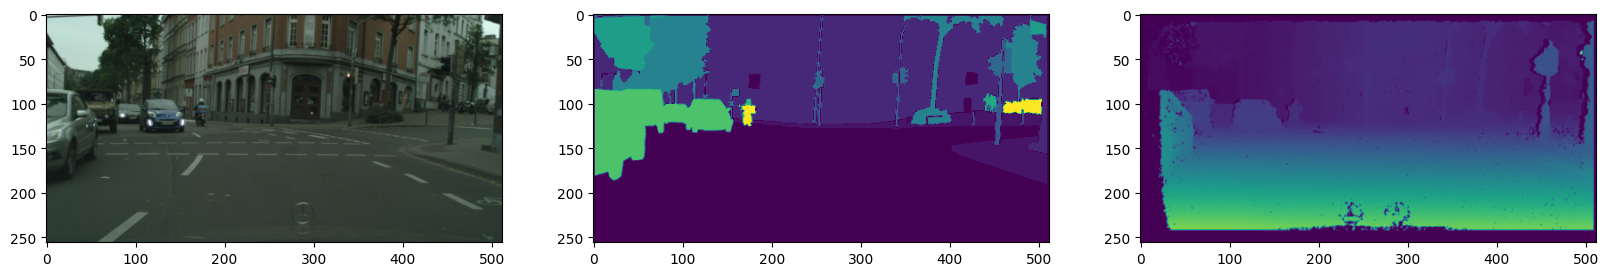

In [6]:
for idx in range(1):
    data, target = train_fine_ds[idx]

    semantic_target = target['semantic']
    depth_target = target['depth']
    
    print(f"data shape: {data.shape}")
    print(f"semantic_target shape: {semantic_target.shape}")
    print(f"depth_target shape: {depth_target.shape}")
    
    num_class = semantic_target.shape[0]
    print(f"Number classes: {num_class}")
    print(f"Classes: {torch.unique(torch.argmax(semantic_target, dim = 0))}")
    
    f, axarr = plt.subplots(1, 3, figsize=(20, 15))
    axarr[0].imshow(data.permute(1, -1, 0).numpy())
    axarr[1].imshow(torch.argmax(semantic_target, dim = 0).unsqueeze(0).permute(1, -1, 0).numpy())
    axarr[2].imshow(depth_target.permute(1, -1, 0).numpy())

In [7]:
train_coarse_ds = CustomCityScapeDS(split = 'train_extra', mode = 'coarse')
valid_coarse_ds = CustomCityScapeDS(split = 'train', mode = 'coarse')
test_coarse_ds = CustomCityScapeDS(split = 'val', mode = 'coarse')

print(len(train_coarse_ds))
print(len(valid_coarse_ds))
print(len(test_coarse_ds))

Data Set Setting Up


100%|███████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 394.05it/s]


Done
Data Set Setting Up


100%|██████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1993.28it/s]


Done
Data Set Setting Up


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1960.57it/s]

Done
19998
2975
500


In [8]:
for ds in [train_coarse_ds, valid_coarse_ds, test_coarse_ds]:
    print(ds.img_dir)
    print(ds.semantic_dir)    
    print(ds.depth_dir)
    print()

/media/mountHDD2/cityscapes/leftImg8bit/train_extra
/media/mountHDD2/cityscapes/gtCoarse/train_extra
/media/mountHDD2/cityscapes/disparity/train_extra

/media/mountHDD2/cityscapes/leftImg8bit/train
/media/mountHDD2/cityscapes/gtCoarse/train
/media/mountHDD2/cityscapes/disparity/train

/media/mountHDD2/cityscapes/leftImg8bit/val
/media/mountHDD2/cityscapes/gtCoarse/val
/media/mountHDD2/cityscapes/disparity/val



data shape: torch.Size([3, 256, 512])
semantic_target shape: torch.Size([19, 256, 512])
depth_target shape: torch.Size([1, 256, 512])
Number classes: 19
Classes: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18])


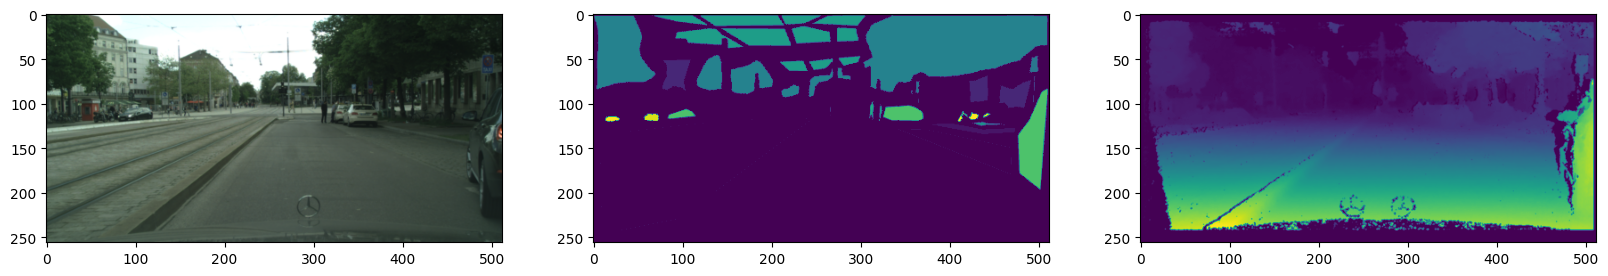

In [9]:
for idx in range(1):
    data, target = train_coarse_ds[idx]

    semantic_target = target['semantic']
    depth_target = target['depth']
    
    print(f"data shape: {data.shape}")
    print(f"semantic_target shape: {semantic_target.shape}")
    print(f"depth_target shape: {depth_target.shape}")
    
    num_class = semantic_target.shape[0]
    print(f"Number classes: {num_class}")
    print(f"Classes: {torch.unique(torch.argmax(semantic_target, dim = 0))}")
    
    f, axarr = plt.subplots(1, 3, figsize=(20, 15))
    axarr[0].imshow(data.permute(1, -1, 0).numpy())
    axarr[1].imshow(torch.argmax(semantic_target, dim = 0).unsqueeze(0).permute(1, -1, 0).numpy())
    axarr[2].imshow(depth_target.permute(1, -1, 0).numpy())